# Google Analytics Customer Revenue Prediction

In this Kaggle competition, the aim is to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. 

In [1]:
import numpy as np 
import pandas as pd 
import json
import bq_helper
from pandas.io.json import json_normalize
import seaborn as sns 
import matplotlib.pyplot as plt 
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
import numpy as np
init_notebook_mode(connected=True)


 Dataset loading and Preparation

In [2]:
json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']
def load_df(filename):
    path = "" + filename
    df = pd.read_csv(path, converters={column: json.loads for column in json_cols}, 
                     dtype={'fullVisitorId': 'str'})
    
    for column in json_cols:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [3]:
train = load_df("train.csv")
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,...,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [4]:
miss_per = {}
for k, v in dict(train.isna().sum(axis=0)).items():
    if v == 0:
        continue
    miss_per[k] = 100 * float(v) / len(train)
    
import operator 
sorted_x = sorted(miss_per.items(), key=operator.itemgetter(1), reverse=True)
print ("There are " + str(len(miss_per)) + " columns with missing values")
kys = [_[0] for _ in sorted_x][::-1]
vls = [_[1] for _ in sorted_x][::-1]

trace1 = go.Bar(y = kys, orientation="h" , x = vls, marker=dict(color="#d6a5ff"))
layout = go.Layout(title="Missing Values Percentage", 
                   xaxis=dict(title="Missing Percentage"), 
                   height=400, margin=dict(l=300, r=300))
figure = go.Figure(data = [trace1], layout = layout)
iplot(figure)

There are 14 columns with missing values


In [5]:
device_cols = ["device_browser", "device_deviceCategory", "device_operatingSystem"]

colors = ["#d6a5ff", "#fca6da", "#f4d39c", "#a9fcca"]
traces = []
for i, col in enumerate(device_cols):
    t = train[col].value_counts()
    traces.append(go.Bar(marker=dict(color=colors[i]),orientation="h", y = t.index[:15], x = t.values[:15]))

fig = tools.make_subplots(rows=1, cols=3, 
                          subplot_titles=["Visits: Category", "Visits: Browser","Visits: OS"]
                          , print_grid=False)
fig.append_trace(traces[1], 1, 1)
fig.append_trace(traces[0], 1, 2)
fig.append_trace(traces[2], 1, 3)

fig['layout'].update(height=400, showlegend=False)
iplot(fig)

train["totals_transactionRevenue"] = train["totals_transactionRevenue"].astype('float')

device_cols = ["device_browser", "device_deviceCategory", "device_operatingSystem"]

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Mean Revenue: Category", "Mean Revenue: Browser","Mean Revenue: OS"], print_grid=False)

colors = ["red", "green", "purple"]
trs = []
for i, col in enumerate(device_cols):
    tmp = train.groupby(col).agg({"totals_transactionRevenue": "mean"}).reset_index().rename(columns={"totals_transactionRevenue" : "Mean Revenue"})
    tmp = tmp.dropna()
    tr = go.Bar(x = tmp["Mean Revenue"], orientation="h", marker=dict(opacity=0.5, color=colors[i]), y = tmp[col])
    trs.append(tr)
    
fig.append_trace(trs[1], 1, 1)
fig.append_trace(trs[0], 1, 2)
fig.append_trace(trs[2], 1, 3)
fig['layout'].update(height=400, showlegend=False)
iplot(fig)

In [6]:
geo_cols = ['geoNetwork_city', 'geoNetwork_continent','geoNetwork_country',
            'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region','geoNetwork_subContinent']
geo_cols = ['geoNetwork_city','geoNetwork_subContinent']

colors = ["#d6a5ff", "#fca6da"]
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["Visits : GeoNetwork Continent", "Visits : GeoNetwork subContinent"], print_grid=False)
trs = []
for i,col in enumerate(geo_cols):
    t = train[col].value_counts()
    tr = go.Bar(x = t.index[:20], marker=dict(color=colors[i]), y = t.values[:20])
    trs.append(tr)

fig.append_trace(trs[1], 1, 1)
fig.append_trace(trs[-1], 1, 2)
fig['layout'].update(height=400, margin=dict(b=150), showlegend=False)
iplot(fig)




geo_cols = ['geoNetwork_continent','geoNetwork_subContinent']
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["Mean Revenue: Continent", "Mean Revenue: SubContinent"], print_grid=False)

colors = ["blue", "orange"]
trs = []
for i, col in enumerate(geo_cols):
    tmp = train.groupby(col).agg({"totals_transactionRevenue": "mean"}).reset_index().rename(columns={"totals_transactionRevenue" : "Mean Revenue"})
    tmp = tmp.dropna()
    tr = go.Bar(x = tmp["Mean Revenue"], orientation="h", marker=dict(opacity=0.5, color=colors[i]), y = tmp[col])
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig['layout'].update(height=400, showlegend=False)
iplot(fig)

In [7]:
tmp = train["geoNetwork_country"].value_counts()



# plotly globe credits - https://www.kaggle.com/arthurtok/generation-unemployed-interactive-plotly-visuals
colorscale = [[0, 'rgb(102,194,165)'], [0.005, 'rgb(102,194,165)'], 
              [0.01, 'rgb(171,221,164)'], [0.02, 'rgb(230,245,152)'], 
              [0.04, 'rgb(255,255,191)'], [0.05, 'rgb(254,224,139)'], 
              [0.10, 'rgb(253,174,97)'], [0.25, 'rgb(213,62,79)'], [1.0, 'rgb(158,1,66)']]

data = [ dict(
        type = 'choropleth',
        autocolorscale = False,
        colorscale = colorscale,
        showscale = True,
        locations = tmp.index,
        z = tmp.values,
        locationmode = 'country names',
        text = tmp.values,
        marker = dict(
            line = dict(color = '#fff', width = 2)) )           ]

layout = dict(
    height=500,
    title = 'Visits by Country',
    geo = dict(
        showframe = True,
        showocean = True,
        oceancolor = '#222',
        projection = dict(
        type = 'orthographic',
            rotation = dict(
                    lon = 60,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = False,
                gridcolor = 'rgb(102, 102, 102)'
            ),
        lataxis = dict(
                showgrid = False,
                gridcolor = 'rgb(102, 102, 102)'
                )
            ),
        )
fig = dict(data=data, layout=layout)
iplot(fig)


tmp = train.groupby("geoNetwork_country").agg({"totals_transactionRevenue" : "mean"}).reset_index()



# plotly globe credits - https://www.kaggle.com/arthurtok/generation-unemployed-interactive-plotly-visuals
colorscale = [[0, 'rgb(102,194,165)'], [0.005, 'rgb(102,194,165)'], 
              [0.01, 'rgb(171,221,164)'], [0.02, 'rgb(230,245,152)'], 
              [0.04, 'rgb(255,255,191)'], [0.05, 'rgb(254,224,139)'], 
              [0.10, 'rgb(253,174,97)'], [0.25, 'rgb(213,62,79)'], [1.0, 'rgb(158,1,66)']]

data = [ dict(
        type = 'choropleth',
        autocolorscale = False,
        colorscale = colorscale,
        showscale = True,
        locations = tmp.geoNetwork_country,
        z = tmp.totals_transactionRevenue,
        locationmode = 'country names',
        text = tmp.totals_transactionRevenue,
        marker = dict(
            line = dict(color = '#fff', width = 2)) )           ]

layout = dict(
    height=500,
    title = 'Mean Revenue by Countries',
    geo = dict(
        showframe = True,
        showocean = True,
        oceancolor = '#222',
        projection = dict(
        type = 'orthographic',
            rotation = dict(
                    lon = 60,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = False,
                gridcolor = 'rgb(102, 102, 102)'
            ),
        lataxis = dict(
                showgrid = False,
                gridcolor = 'rgb(102, 102, 102)'
                )
            ),
        )
fig = dict(data=data, layout=layout)
iplot(fig)

In [8]:
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["TrafficSource Campaign (not-set removed)", "TrafficSource Medium"], print_grid=False)

colors = ["#d6a5ff", "#fca6da", "#f4d39c", "#a9fcca"]
t1 = train["trafficSource_campaign"].value_counts()
t2 = train["trafficSource_medium"].value_counts()
tr1 = go.Bar(x = t1.index, y = t1.values, marker=dict(color=colors[3]))
tr2 = go.Bar(x = t2.index, y = t2.values, marker=dict(color=colors[2]))
tr3 = go.Bar(x = t1.index[1:], y = t1.values[1:], marker=dict(color=colors[0]))
tr4 = go.Bar(x = t2.index[1:], y = t2.values[1:])

fig.append_trace(tr3, 1, 1)
fig.append_trace(tr2, 1, 2)
fig['layout'].update(height=400, showlegend=False)
iplot(fig)

In [9]:
tmp = train["channelGrouping"].value_counts()
colors = ["#8d44fc", "#ed95d5", "#caadf7", "#6161b7", "#7e7eba", "#babad1"]
trace = go.Pie(labels=tmp.index, values=tmp.values, marker=dict(colors=colors))
layout = go.Layout(title="Channel Grouping", height=400)
fig = go.Figure(data = [trace], layout = layout)
iplot(fig, filename='basic_pie_chart')

In [10]:
train['date'] = train['date'].astype(str)
train["date1"] = train["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
train["date1"] = pd.to_datetime(train["date1"])
tmp = train['date1'].value_counts().to_frame().reset_index().sort_values('index')
tmp = tmp.rename(columns = {"index" : "dateX", "date1" : "visits"})

tr = go.Scatter(mode="lines", x = tmp["dateX"].astype(str), y = tmp["visits"])
layout = go.Layout(title="Visits by date", height=400)
fig = go.Figure(data = [tr], layout = layout)
iplot(fig)


tmp = train.groupby("date1").agg({"totals_transactionRevenue" : "mean"}).reset_index()
tmp = tmp.rename(columns = {"date1" : "dateX", "totals_transactionRevenue" : "mean_revenue"})
tr = go.Scatter(mode="lines", x = tmp["dateX"].astype(str), y = tmp["mean_revenue"])
layout = go.Layout(title="MonthlyRevenue by date", height=400)
fig = go.Figure(data = [tr], layout = layout)
iplot(fig)

In [11]:
train["month"] = train['date1'].dt.month
train["day"] = train['date1'].dt.day
train["weekday"] = train['date1'].dt.weekday

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Visits by Month", "Visits by MonthDay", "Visits by WeekDay"], print_grid=False)
trs = []
for i,col in enumerate(["month", "day", "weekday"]):
    t = train[col].value_counts()
    tr = go.Bar(x = t.index, marker=dict(color=colors[i]), y = t.values)
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig.append_trace(trs[2], 1, 3)
fig['layout'].update(height=400, showlegend=False)
iplot(fig)



tmp1 = train.groupby('month').agg({"totals_transactionRevenue" : "mean"}).reset_index()
tmp2 = train.groupby('day').agg({"totals_transactionRevenue" : "mean"}).reset_index()
tmp3 = train.groupby('weekday').agg({"totals_transactionRevenue" : "mean"}).reset_index()

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["MeanRevenue by Month", "MeanRevenue by MonthDay", "MeanRevenue by WeekDay"], print_grid=False)
tr1 = go.Bar(x = tmp1.month, marker=dict(color="red", opacity=0.5), y = tmp1.totals_transactionRevenue)
tr2 = go.Bar(x = tmp2.day, marker=dict(color="orange", opacity=0.5), y = tmp2.totals_transactionRevenue)
tr3 = go.Bar(x = tmp3.weekday, marker=dict(color="green", opacity=0.5), y = tmp3.totals_transactionRevenue)

fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 2)
fig.append_trace(tr3, 1, 3)
fig['layout'].update(height=400, showlegend=False)
iplot(fig)

In [12]:
vn = train["visitNumber"].value_counts()
def vn_bins(x):
    if x == 1:
        return "1" 
    elif x < 5:
        return "2-5"
    elif x < 10:
        return "5-10"
    elif x < 50:
        return "10-50"
    elif x < 100:
        return "50-100"
    else:
        return "100+"
    
train["visitNumber_b"] = train["visitNumber"].apply(vn_bins)
vn = train["visitNumber_b"].value_counts()

trace1 = go.Bar(y = vn.index[::-1], orientation="h" , x = vn.values[::-1], marker=dict(color="#7af9ad"))
layout = go.Layout(title="Visit Numbers Distribution", 
                   xaxis=dict(title="Frequency"),yaxis=dict(title="VisitNumber") ,
                   height=400, margin=dict(l=300, r=300))
figure = go.Figure(data = [trace1], layout = layout)
iplot(figure)

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

agg_dict = {}
for col in ["totals_bounces", "totals_hits", "totals_newVisits", "totals_pageviews", "totals_transactionRevenue"]:
    train[col] = train[col].astype('float')
    agg_dict[col] = "sum"
tmp = train.groupby("fullVisitorId").agg(agg_dict).reset_index()
tmp.head()

,fullVisitorId,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_transactionRevenue
0,0000010278554503158,0.0,11.0,1.0,8.0,0.0
1,0000020424342248747,0.0,17.0,1.0,13.0,0.0
2,0000027376579751715,0.0,6.0,1.0,5.0,0.0
3,0000039460501403861,0.0,2.0,1.0,2.0,0.0
4,0000040862739425590,0.0,5.0,1.0,5.0,0.0


There are 9996 visitors in the train dataset having non zero total transaction revenue


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



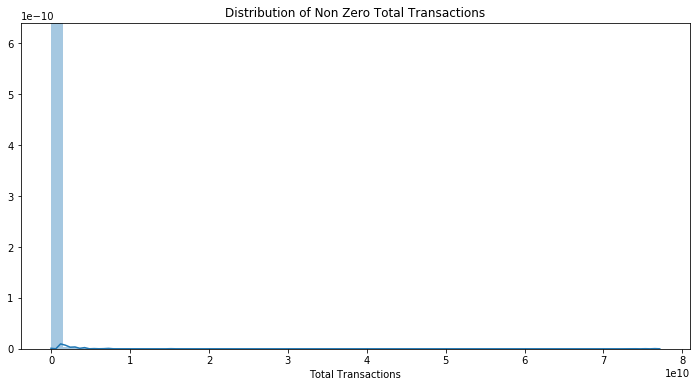

In [14]:
non_zero = tmp[tmp["totals_transactionRevenue"] > 0]["totals_transactionRevenue"]
print ("There are " + str(len(non_zero)) + " visitors in the train dataset having non zero total transaction revenue")

plt.figure(figsize=(12,6))
sns.distplot(non_zero)
plt.title("Distribution of Non Zero Total Transactions");
plt.xlabel("Total Transactions");


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



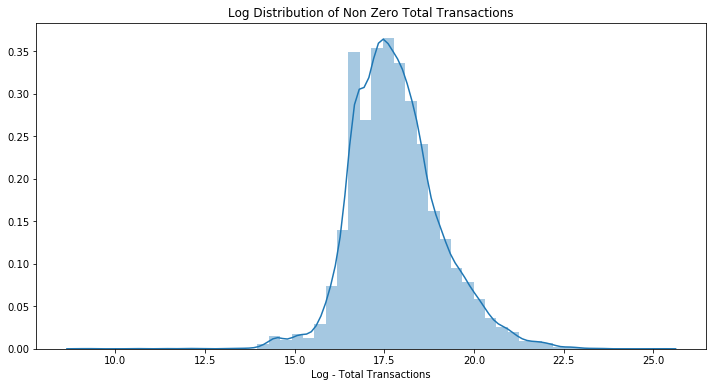

In [15]:
plt.figure(figsize=(12,6))
sns.distplot(np.log1p(non_zero))
plt.title("Log Distribution of Non Zero Total Transactions");
plt.xlabel("Log - Total Transactions");

In [16]:
def getbin_hits(x):
    if x < 5:
        return "1-5"
    elif x < 10:
        return "5-10"
    elif x < 30:
        return "10-30"
    elif x < 50:
        return "30-50"
    elif x < 100:
        return "50-100"
    else:
        return "100+"

tmp["total_hits_bin"] = tmp["totals_hits"].apply(getbin_hits)
tmp["totals_bounces_bin"] = tmp["totals_bounces"].apply(lambda x : str(x) if x <= 5 else "5+")
tmp["totals_pageviews_bin"] = tmp["totals_pageviews"].apply(lambda x : str(x) if x <= 50 else "50+")

t1 = tmp["total_hits_bin"].value_counts()
t2 = tmp["totals_bounces_bin"].value_counts()
t3 = tmp["totals_newVisits"].value_counts()
t4 = tmp["totals_pageviews_bin"].value_counts()

fig = tools.make_subplots(rows=2, cols=2, subplot_titles=["Total Hits per User", "Total Bounces per User", 
                                                         "Total NewVistits per User", "Total PageViews per User"], print_grid=False)

tr1 = go.Bar(x = t1.index[:20], y = t1.values[:20])
tr2 = go.Bar(x = t2.index[:20], y = t2.values[:20])
tr3 = go.Bar(x = t3.index[:20], y = t3.values[:20])
tr4 = go.Bar(x = t4.index, y = t4.values)

fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 2)
fig.append_trace(tr3, 2, 1)
fig.append_trace(tr4, 2, 2)

fig['layout'].update(height=700, showlegend=False)
iplot(fig)